# TVB for Epilepsy


### Basic configurations

In [3]:
!echo $SHELL
!source activage python2.7.3
%matplotlib inline

import os
import warnings
from copy import deepcopy

import numpy as np

from tvb_epilepsy.base.constants.config import Config
from tvb_epilepsy.base.utils.log_error_utils import initialize_logger
from tvb_epilepsy.io.tvb_data_reader import TVBReader
from tvb_epilepsy.io.h5_reader import H5Reader
from tvb_epilepsy.io.h5_writer import H5Writer
from tvb_epilepsy.plot.plotter import Plotter

input_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "CC", "TVB3", "tvbHead")
# input_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "CC", "TVB3", "Head")
output_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "tests")
config = Config(head_folder=input_folder, output_base=output_folder, data_mode="tvb") #, data_mode="java"
logger = initialize_logger(__name__, config.out.FOLDER_LOGS)
reader = TVBReader() if config.input.IS_TVB_MODE else H5Reader()
writer = H5Writer()
plotter = Plotter(config)
plotter.plot_head(head)

SyntaxError: Unexpected identifier

### Reading data

In [1]:
logger.info("Reading from: " + config.input.HEAD)
head = reader.read_head(config.input.HEAD)
# Plot
head.plot(show_flag=SHOW_FLAG, save_flag=SAVE_FLAG, figure_dir=FOLDER_FIGURES, figure_format=FIG_FORMAT)

SyntaxError: Invalid or unexpected token

In [5]:
# Read clinical hypothesis... 
from tvb_epilepsy.custom.readers_custom import CustomReader
reader = CustomReader()
clinical_hypothesis = reader.read_epileptogenicity(PATIENT_VIRTUAL_HEAD, name=HYPOTHESIS_NAME)
disease_indices, = np.where(clinical_hypothesis > 0.0)
disease_values = clinical_hypothesis[disease_indices]
for iRegion in range(len(disease_indices)):
    print head.connectivity.region_labels[disease_indices[iRegion]], disease_values[iRegion]

Reading Epileptogenicity from: /Users/dionperd/CBR/VEP/CC/TVB2/tvbHead/Head/clinical_hypothesis_new/clinical_hypothesis_new.h5
Structures: [u'values']
Values expected shape: (87,)
Actual values shape (87,)
ctx-rh-caudalanteriorcingulate 0.198067650199
ctx-rh-caudalmiddlefrontal 0.500000059605
ctx-rh-lateralorbitofrontal 0.198067650199
ctx-rh-medialorbitofrontal 0.202898547053
ctx-rh-posteriorcingulate 0.198067620397
ctx-rh-precuneus 0.198067635298
ctx-rh-rostralmiddlefrontal 0.5
ctx-rh-superiorfrontal 0.79710149765
ctx-rh-superiorparietal 0.198067620397


In [6]:
#...and formulate a VEP hypothesis
from tvb_epilepsy.base.model.disease_hypothesis import DiseaseHypothesis

# Regions of Pathological Excitability hypothesis:
x0_indices = []
x0_values = []
# Regions of Model Epileptogenicity hypothesis:
e_indices = disease_indices.tolist()
e_values = disease_values.tolist()

# Regions of Connectivity hypothesis:
w_indices = []
w_values = []

n_x0 = len(x0_indices)
n_e = len(e_indices)
n_w = len(w_indices)
n_disease = len(disease_indices)
all_regions_indices = np.array(range(head.number_of_regions))
healthy_indices = np.delete(all_regions_indices, disease_indices).tolist()
n_healthy = len(healthy_indices)

hyp = DiseaseHypothesis(head.connectivity.number_of_regions, 
                        excitability_hypothesis={}, 
                        epileptogenicity_hypothesis={tuple(disease_indices): disease_values},
                        connectivity_hypothesis={})

logger.info("\n\nRunning hypothesis: " + hyp.name)

In [7]:
# Model configuration
from tvb_epilepsy.service.model_configuration_service import ModelConfigurationService

logger.info("\n\nCreating model configuration...")
model_configuration_service = ModelConfigurationService(hyp.number_of_regions)
model_configuration_service.write_to_h5(FOLDER_RES, hyp.name + "_model_config_service.h5")

model_configuration = model_configuration_service.configure_model_from_hypothesis(hyp, 
                                                                                  head.connectivity.normalized_weights)
model_configuration.write_to_h5(FOLDER_RES, hyp.name + "_ModelConfig.h5")



File /Users/dionperd/CBR/VEP/CC/TVB2/tvbHead/Head/clinical_hypothesis_new/results/data/Epileptogenicity_Hypothesis_model_config_service.h5 already exists. Enter a different name or press enter to overwrite file: 


File /Users/dionperd/CBR/VEP/CC/TVB2/tvbHead/Head/clinical_hypothesis_new/results/data/Epileptogenicity_Hypothesis_ModelConfig.h5 already exists. Enter a different name or press enter to overwrite file: 




File /Users/dionperd/CBR/VEP/CC/TVB2/tvbHead/Head/clinical_hypothesis_new/results/data/LSA_Epileptogenicity_Hypothesis_LSAConfig.h5 already exists. Enter a different name or press enter to overwrite file: 


File /Users/dionperd/CBR/VEP/CC/TVB2/tvbHead/Head/clinical_hypothesis_new/results/data/LSA_Epileptogenicity_Hypothesis_LSA.h5 already exists. Enter a different name or press enter to overwrite file: 


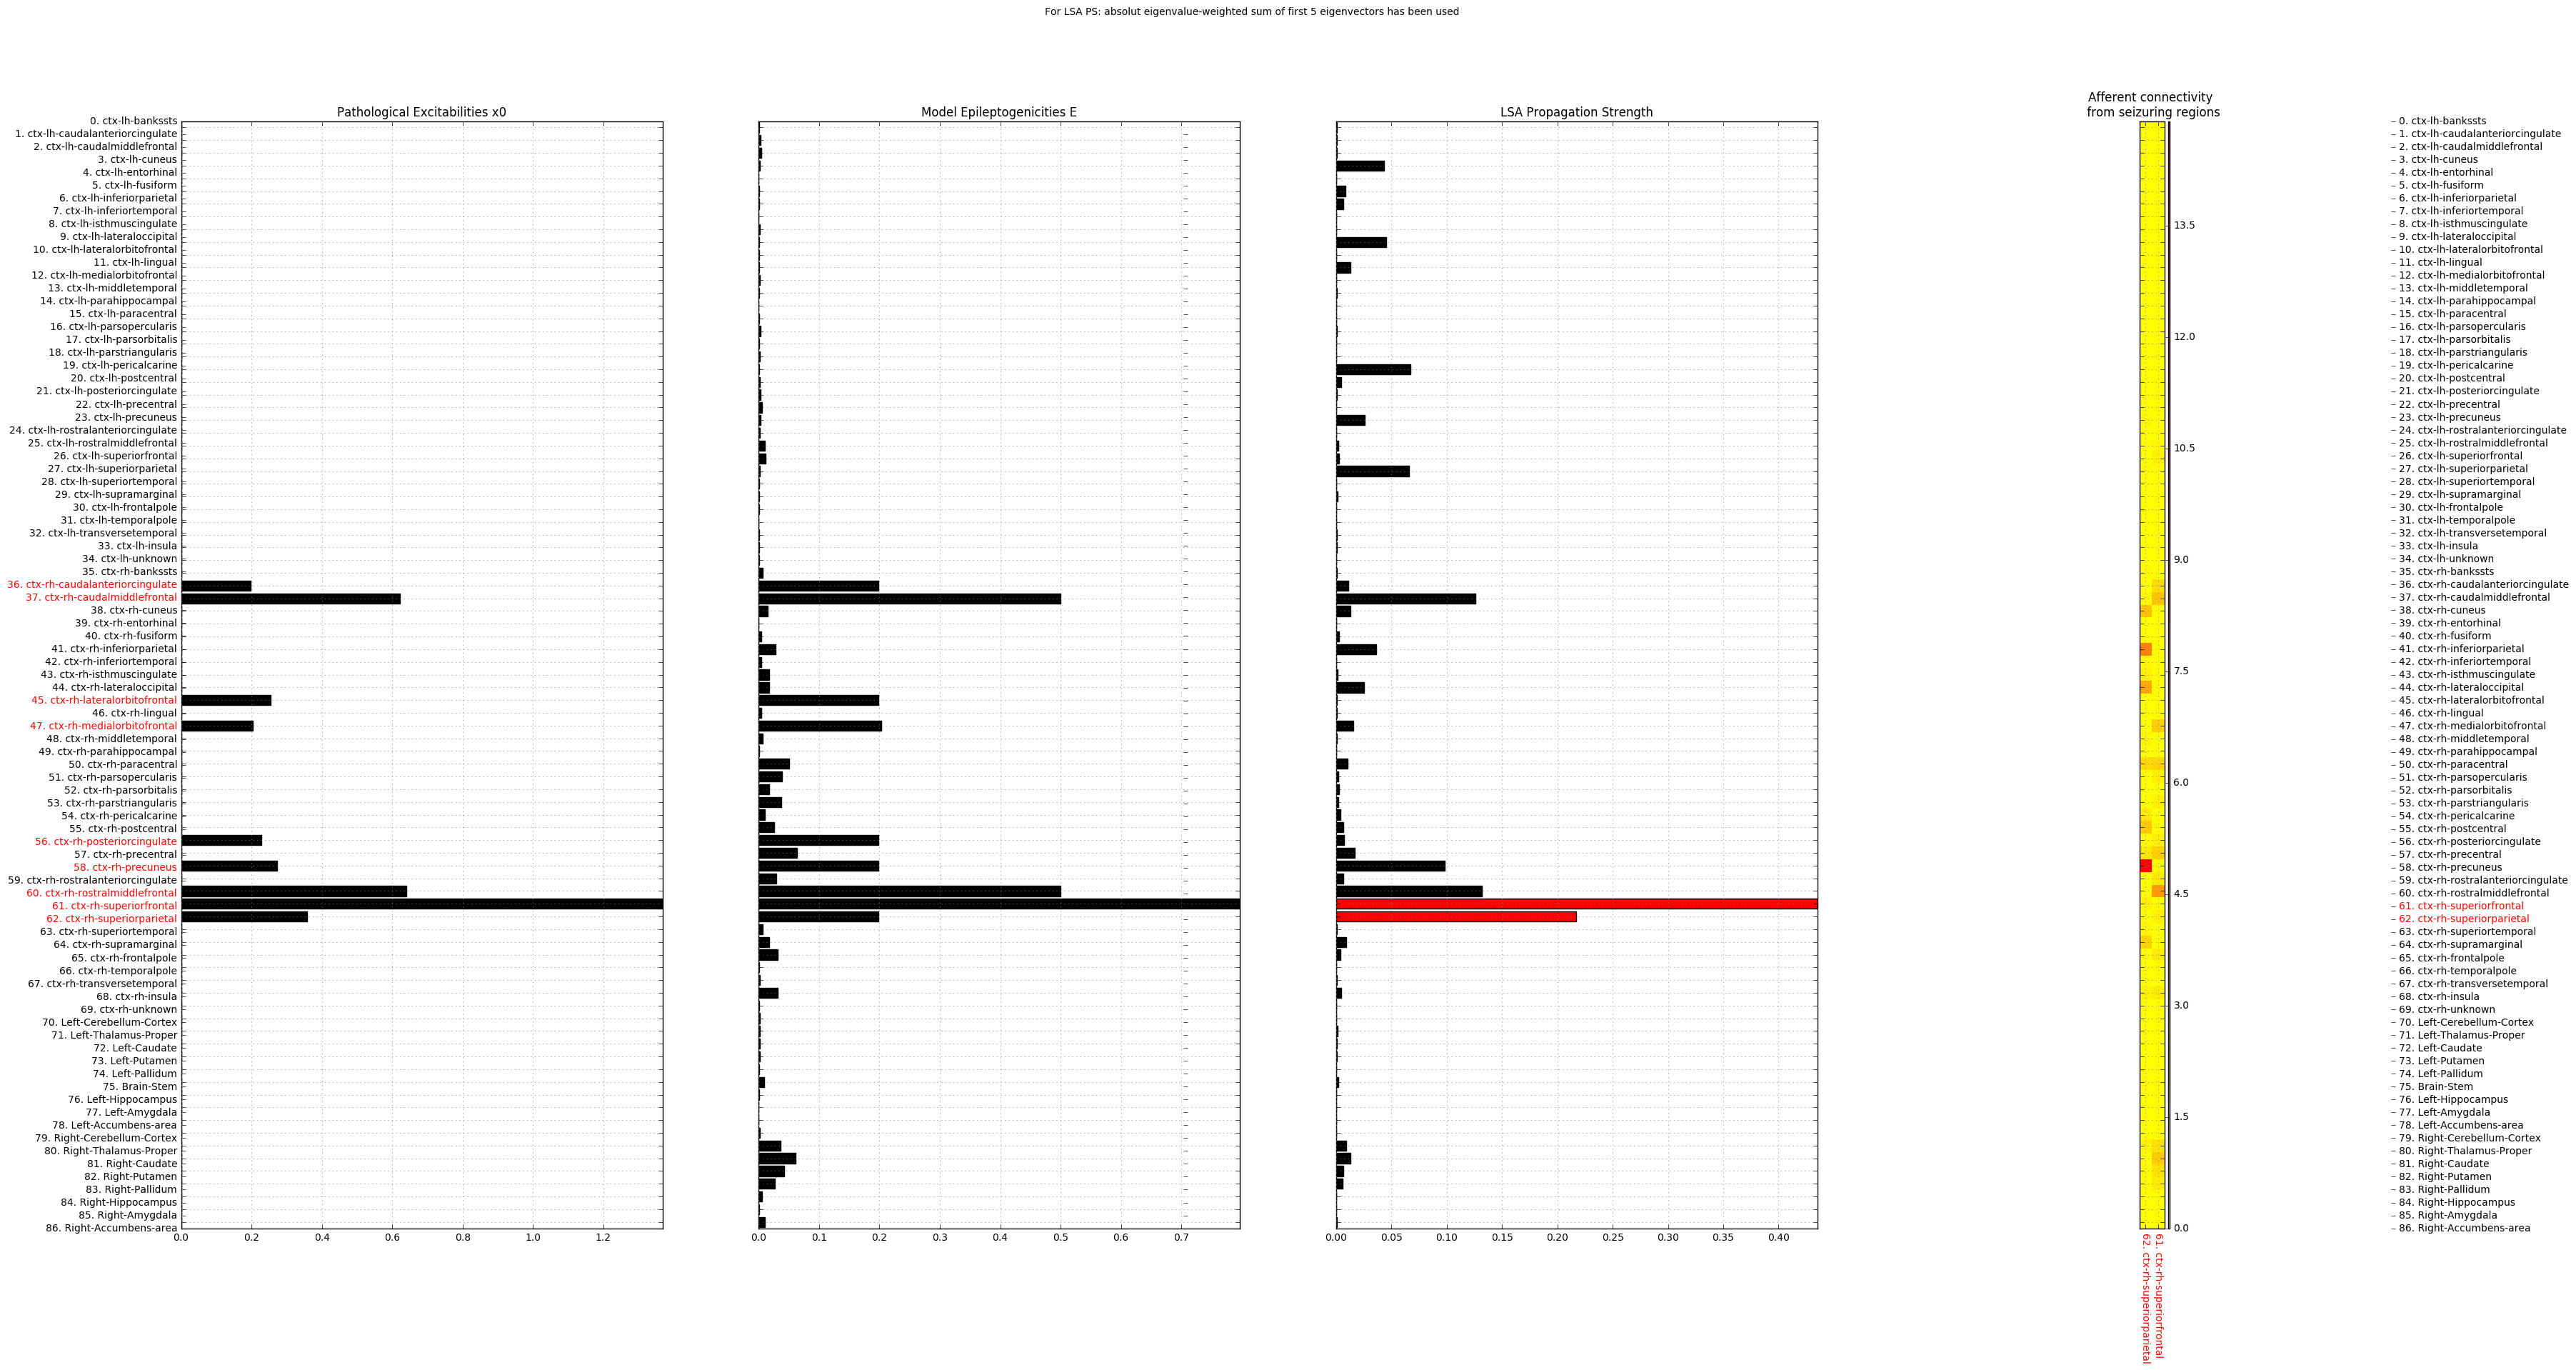

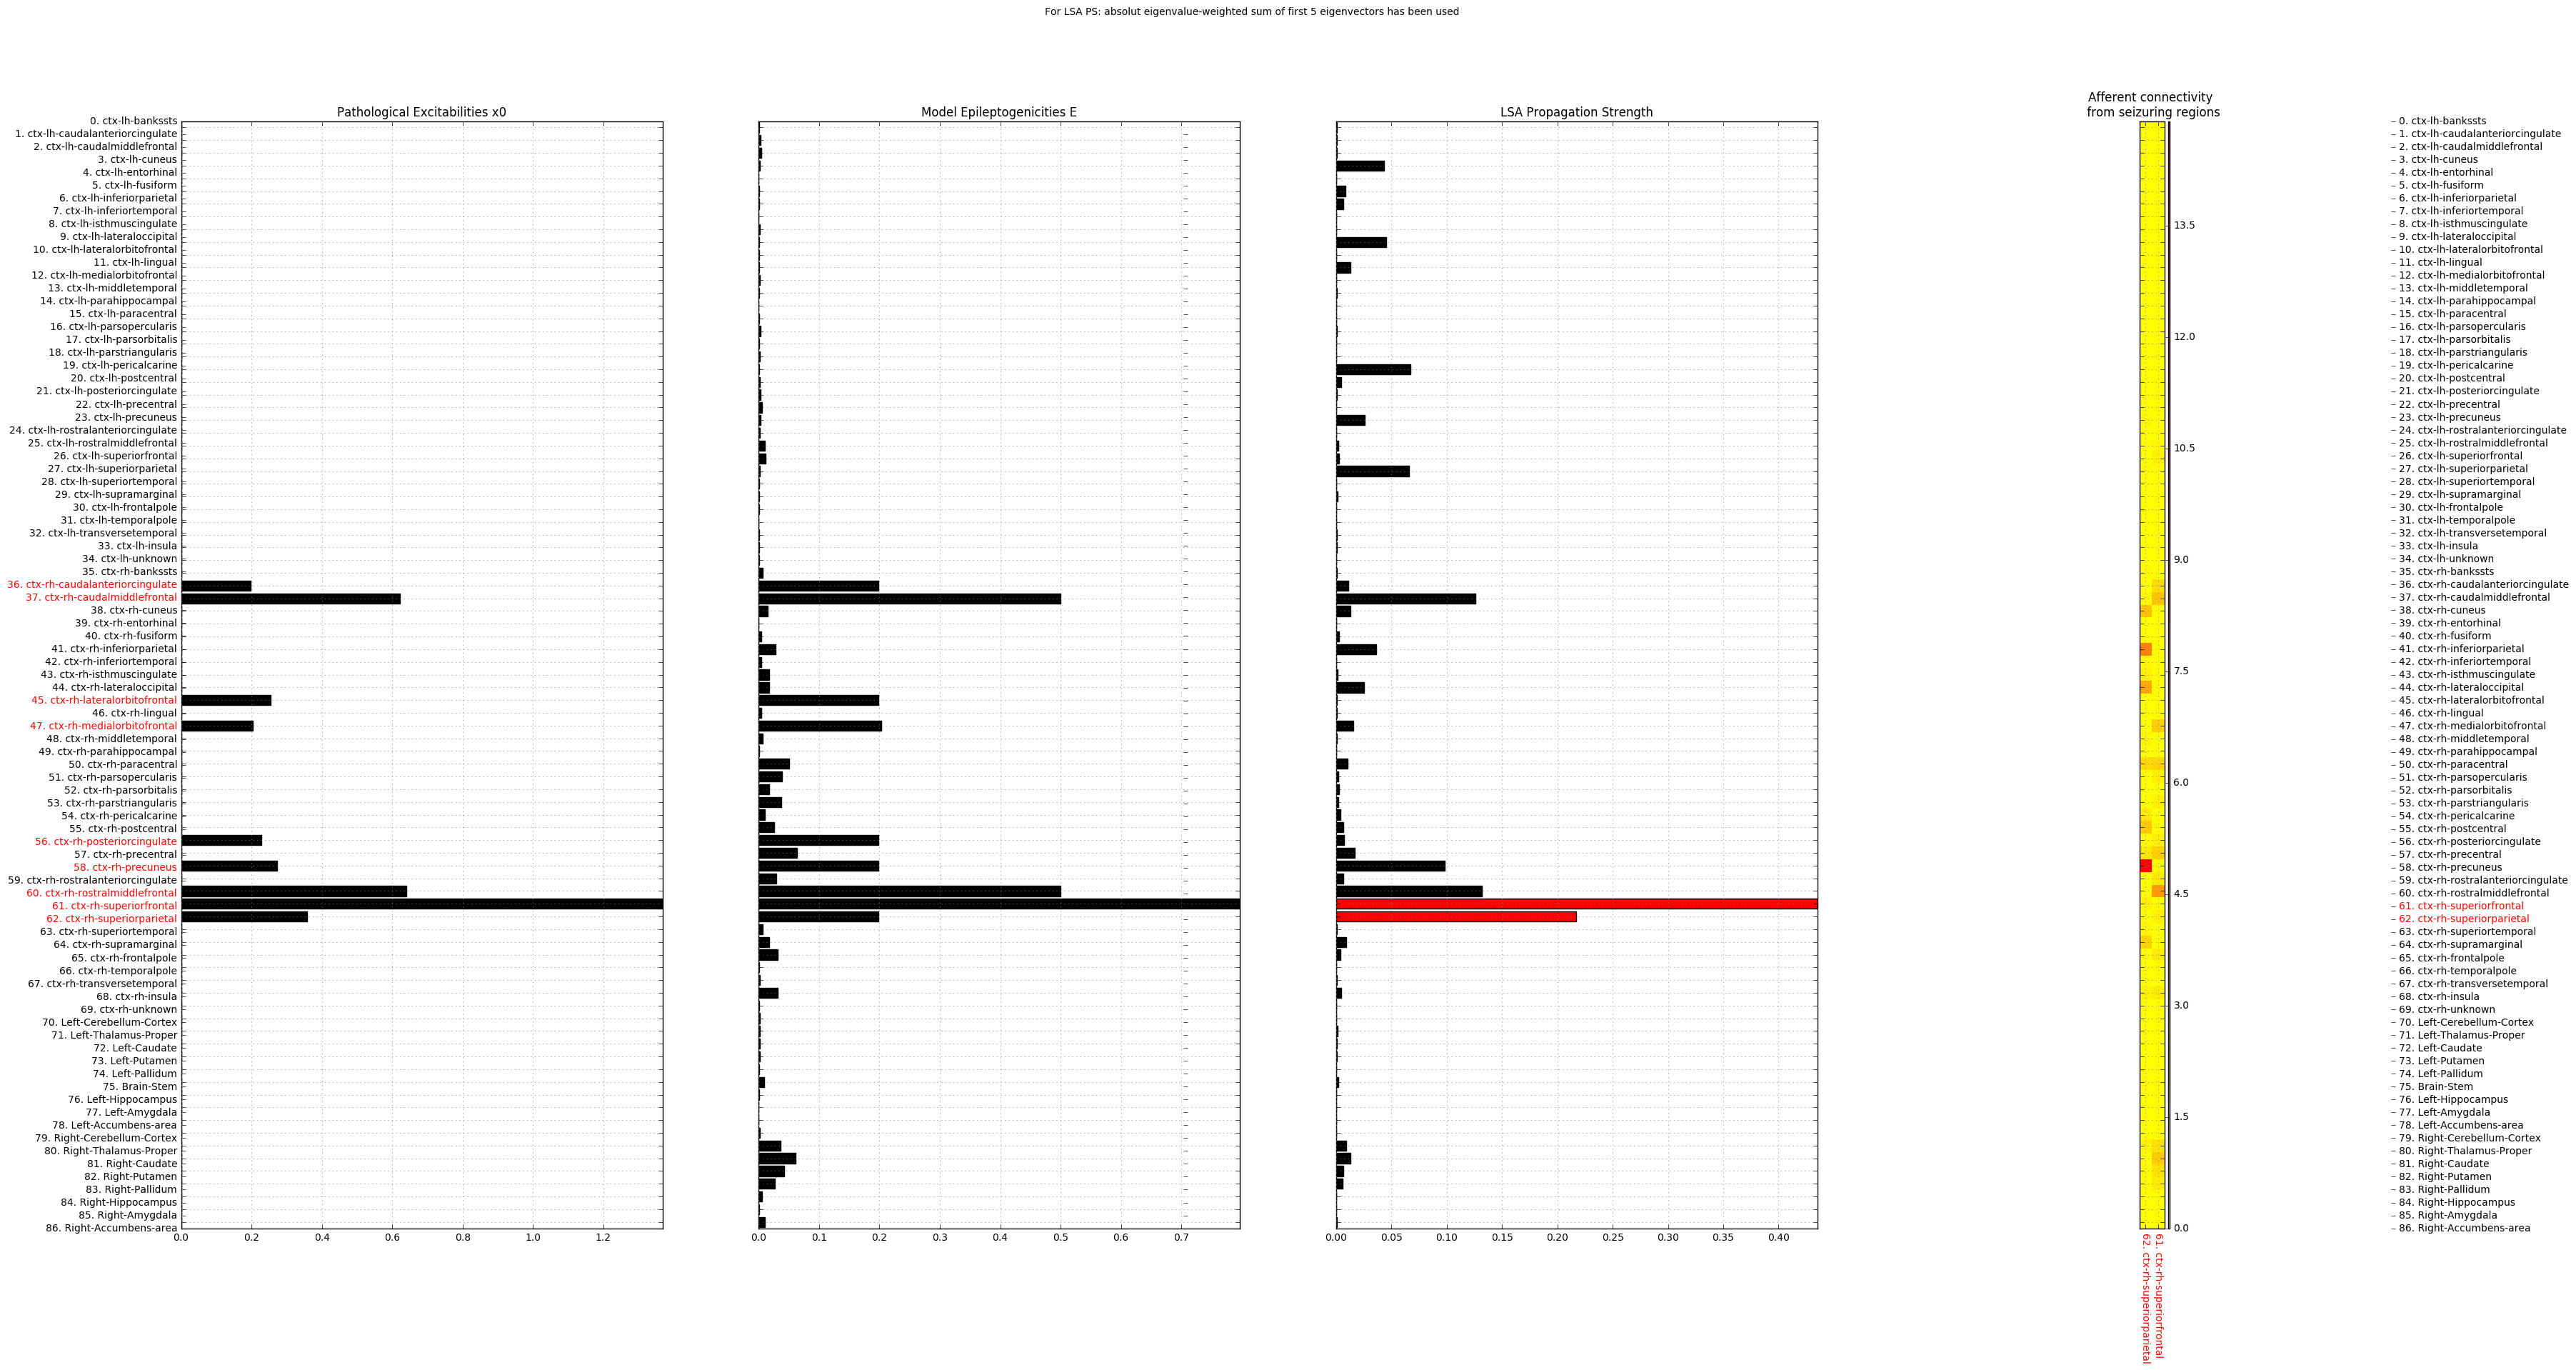

In [8]:
# Run linear stability analysis
from tvb_epilepsy.service.lsa_service import LSAService

# Options for eigen_vectors_number: 
# "auto_eigenvals": eigenvalues curve elbow point selection,
# "auto_disease": len(n_disease), 
# "auto_epileptogenicity": Model Epileptogenicity curve elbow point selection,
# "auto_excitability": Pathological Excitability curve elbow point selection
# or "user_defined": a number equal to from 1 to hypothesis.number_of_regions
lsa_service = LSAService(eigen_vectors_number=None, 
                         eigen_vectors_number_selection="auto_eigenvals", 
                         weighted_eigenvector_sum=True)
lsa_hypothesis = lsa_service.run_lsa(hyp, model_configuration)

lsa_service.write_to_h5(FOLDER_RES, lsa_hypothesis.name + "_LSAConfig.h5")
lsa_hypothesis.write_to_h5(FOLDER_RES, lsa_hypothesis.name + "_LSA.h5")

# Plot
lsa_service.plot_lsa(lsa_hypothesis, model_configuration, head.connectivity.region_labels,  None, 
                     show_flag=SHOW_FLAG, save_flag=SAVE_FLAG, figure_dir=FOLDER_FIGURES, figure_format=FIG_FORMAT)

/Users/dionperd/CBR/software/git/tvb-epilepsy/tvb_epilepsy/base/utils.py:47: UserWarning: 


Selecting scipy module for truncated distributions
  warnings.warn(msg)
/Users/dionperd/anaconda/anaconda/envs/python2_7/lib/python2.7/site-packages/sqlalchemy/ext/declarative/api.py:173: SAWarning: Unmanaged access of declarative attribute __tablename__ from non-mapped class Volume
  (desc.fget.__name__, cls.__name__))
/Users/dionperd/anaconda/anaconda/envs/python2_7/lib/python2.7/site-packages/sqlalchemy/ext/declarative/api.py:173: SAWarning: Unmanaged access of declarative attribute __tablename__ from non-mapped class Connectivity
  (desc.fget.__name__, cls.__name__))
/Users/dionperd/anaconda/anaconda/envs/python2_7/lib/python2.7/site-packages/sqlalchemy/ext/declarative/api.py:173: SAWarning: Unmanaged access of declarative attribute __tablename__ from non-mapped class Sensors
  (desc.fget.__name__, cls.__name__))
/Users/dionperd/anaconda/anaconda/envs/python2_7/lib/python2.7/site-packages/s


Generated a parameter search exploration for LSA,
with 88 parameters of 100 values each,
leading to 100 total execution loops

Executing loop 1 of 100

Executing loop 10 of 100

Executing loop 20 of 100

Executing loop 30 of 100

Executing loop 40 of 100

Executing loop 50 of 100

Executing loop 60 of 100

Executing loop 70 of 100

Executing loop 80 of 100

Executing loop 90 of 100

Executing loop 100 of 100


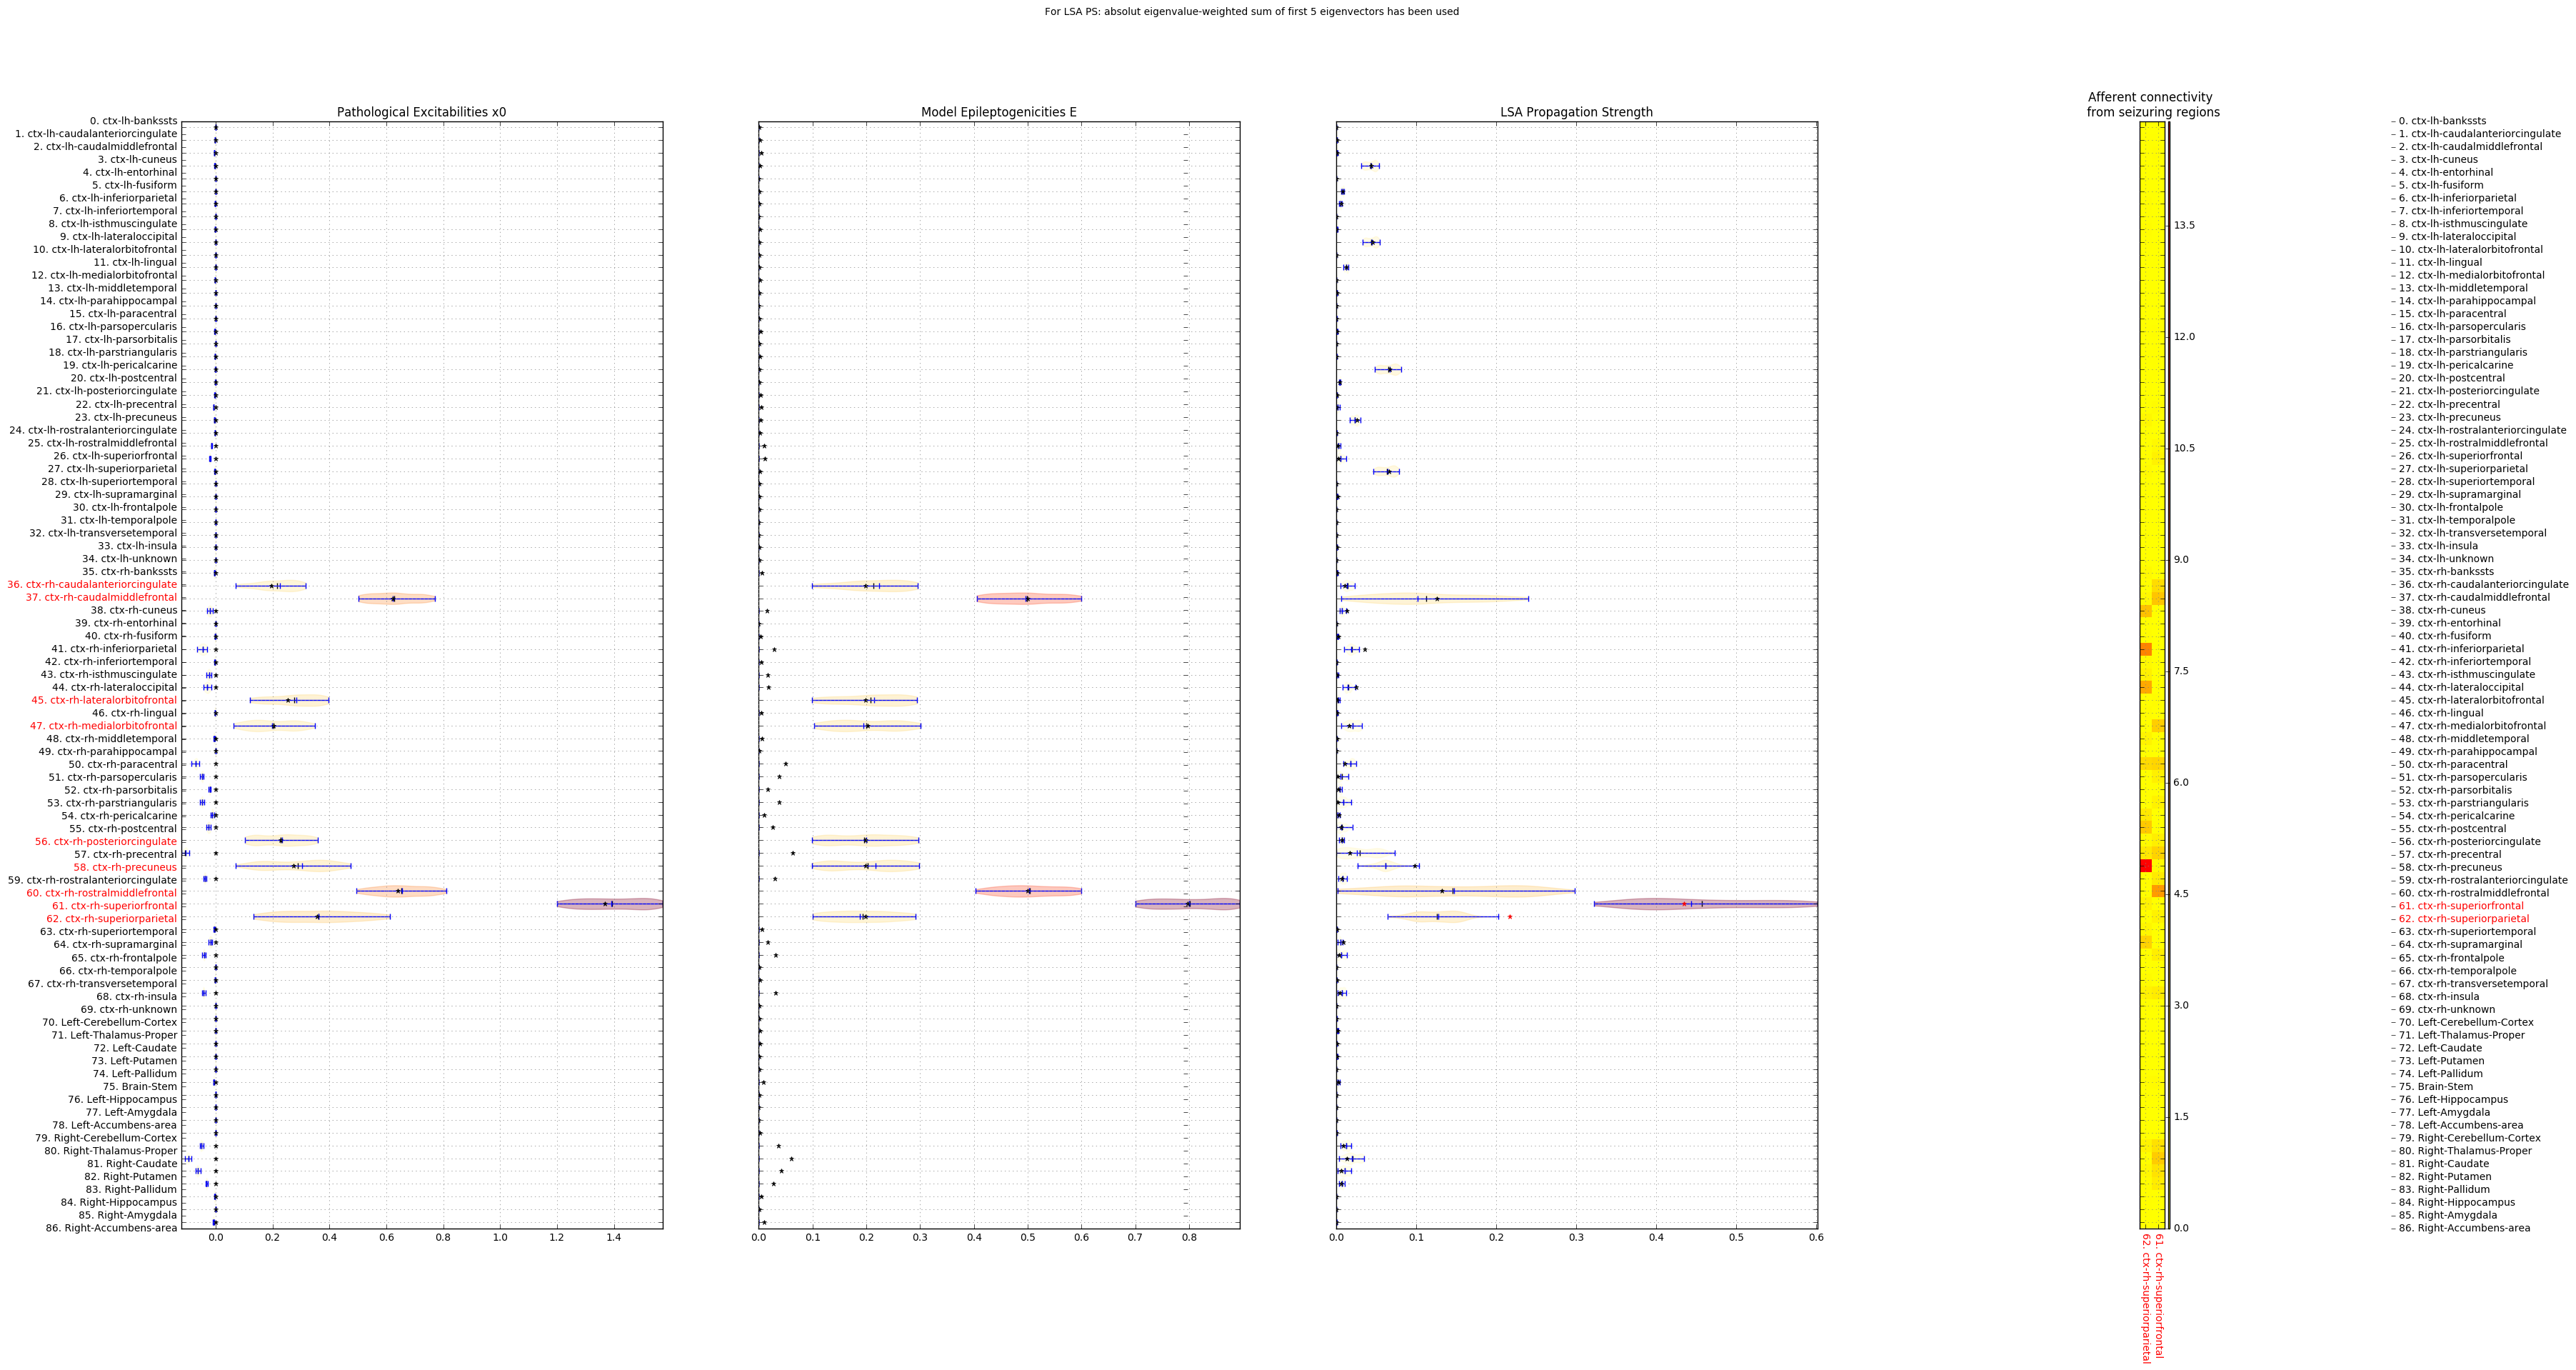



File /Users/dionperd/CBR/VEP/CC/TVB2/tvbHead/Head/clinical_hypothesis_new/results/data/LSA_Epileptogenicity_Hypothesis_PSE_LSA_Service.h5 already exists. Enter a different name or press enter to overwrite file: 


File /Users/dionperd/CBR/VEP/CC/TVB2/tvbHead/Head/clinical_hypothesis_new/results/data/LSA_Epileptogenicity_Hypothesis_PSE_LSA_results.h5 already exists. Enter a different name or press enter to overwrite file: 


In [ ]:
# Run parameter search exploration for linear stability analysis around the clinical hypothesis

from tvb_epilepsy.base.utils import linear_index_to_coordinate_tuples, dicts_of_lists_to_lists_of_dicts, list_of_dicts_to_dicts_of_ndarrays
    
pse_params = {"path": [], "indices": [], "name": [], "samples": []}

# First sample the parameters of interest:
from tvb_epilepsy.service.sampling_service import StochasticSamplingService

# Some constants
n_samples=100
half_range = 0.1 
MAX_DISEASE_VALUE = 1.0 - 10 ** -3

# The connectivity matrix:
connectivity_matrix = head.connectivity.normalized_weights

# First build from the hypothesis the input parameters of the parameter search exploration.
# These can be either originating from excitability, epileptogenicity or connectivity hypotheses,
# or they can relate to the global coupling scaling (parameter K of the model configuration)

# Pathological Excitability
for ii in range(len(lsa_hypothesis.x0_values)):
    pse_params["indices"].append([ii])
    pse_params["path"].append("hypothesis.x0_values")
    pse_params["name"].append(str(head.connectivity.region_labels[lsa_hypothesis.x0_indices[ii]]) + " Excitability")

    # Now generate samples using a truncated uniform distribution (using inverse sampling with scipy)
    sampler = StochasticSamplingService(n_samples=n_samples, n_outputs=1, sampling_module="scipy",
                                        random_seed=None,
                                        trunc_limits={"high": MAX_DISEASE_VALUE},
                                        sampler="uniform",
                                        loc=lsa_hypothesis.x0_values[ii] - half_range, scale=2 * half_range)
    pse_params["samples"].append(sampler.generate_samples())

# Model Epileptogenicity
for ii in range(len(lsa_hypothesis.e_values)):
    pse_params["indices"].append([ii])
    pse_params["path"].append("hypothesis.e_values")
    pse_params["name"].append(str(head.connectivity.region_labels[lsa_hypothesis.e_indices[ii]]) + " Epileptogenicity")

    # Now generate samples using a truncated uniform distribution (using inverse sampling with scipy)
    sampler = StochasticSamplingService(n_samples=n_samples, n_outputs=1, sampling_module="scipy",
                                        random_seed=None,
                                        trunc_limits={"high": MAX_DISEASE_VALUE},
                                        sampler="uniform",
                                        loc=lsa_hypothesis.e_values[ii] - half_range, scale=2 * half_range)
    pse_params["samples"].append(sampler.generate_samples())

# Connectivity
for ii in range(len(lsa_hypothesis.w_values)):
    pse_params["indices"].append([ii])
    pse_params["path"].append("hypothesis.w_values")
    inds = linear_index_to_coordinate_tuples(lsa_hypothesis.w_indices[ii], connectivity_matrix.shape)
    if len(inds) == 1:
        pse_params["name"].append(str(region_labels[inds[0][0]]) + "-" +
                                    str(region_labels[inds[0][0]]) + " Connectivity")
    else:
        pse_params["name"].append("Connectivity[" + str(inds), + "]")

    # Now generate samples using a truncated normal distribution (using inverse sampling with scipy)
    sampler = StochasticSamplingService(n_samples=n_samples, n_outputs=1, sampling_module="scipy",
                                        random_seed=None,
                                        trunc_limits={"high": MAX_DISEASE_VALUE},
                                        sampler="norm", loc=lsa_hypothesis.w_values[ii], scale=half_range)
    pse_params["samples"].append(sampler.generate_samples())

# Global coupling
kloc = model_configuration_service.K_unscaled[0]
global_coupling = [{}]
for val in global_coupling:
    pse_params["path"].append("model.configuration.service.K_unscaled")
    inds = val.get("indices", all_regions_indices)
    if np.all(inds == all_regions_indices):
        pse_params["name"].append("Global coupling")
    else:
        pse_params["name"].append("Afferent coupling[" + str(inds) + "]")
    pse_params["indices"].append(inds)

    # Now generate samples susing a truncated normal distribution
    sampler = StochasticSamplingService(n_samples=n_samples, n_outputs=1, sampling_module="scipy",
                                        random_seed=None,
                                        trunc_limits={"low": 0.0}, sampler="norm", loc=kloc, scale=30 * half_range)
    pse_params["samples"].append(sampler.generate_samples())

# Convert to a list of dicts
pse_params_list = dicts_of_lists_to_lists_of_dicts(pse_params)

# Optionally, add a random jitter to the healthy regions Pathological Excitability...:
healthy_regions_parameters=[{}]
for val in healthy_regions_parameters:
    inds = val.get("indices", healthy_indices)
    name = val.get("name", "x0")
    n_params = len(inds)
    sampler = StochasticSamplingService(n_samples=n_samples, n_outputs=n_params, sampler="uniform",
                                        trunc_limits={"low": 0.0}, sampling_module="scipy",
                                        random_seed=None,
                                        loc=0.0, scale=2 * half_range)

    samples = sampler.generate_samples()
    for ii in range(n_params):
        pse_params_list.append({"path": "model_configuration_service." + name, "samples": samples[ii],
                                    "indices": [inds[ii]], "name": name})
        
# Now run pse:
from tvb_epilepsy.service.pse_service import PSEService
pse = PSEService("LSA", hypothesis=lsa_hypothesis, params_pse=pse_params_list)
pse_results, execution_status = pse.run_pse(connectivity_matrix, grid_mode=False, lsa_service_input=lsa_service,
                                            model_configuration_service_input=model_configuration_service)

# Convert results to a dict of numpy arrays:
pse_results = list_of_dicts_to_dicts_of_ndarrays(pse_results)

# Plot
lsa_service.plot_lsa(lsa_hypothesis, model_configuration, head.connectivity.region_labels, pse_results, 
                     show_flag=SHOW_FLAG, save_flag=SAVE_FLAG, figure_dir=FOLDER_FIGURES, figure_format=FIG_FORMAT)

# Write pse service and results to h5 files
pse.write_to_h5(FOLDER_RES, lsa_hypothesis.name + "_PSE_LSA_Service.h5")
convert_to_h5_model(pse_results).write_to_h5(FOLDER_RES, lsa_hypothesis.name + "_PSE_LSA_results.h5")



In [ ]:
# Simulation
from tvb_epilepsy.base.constants import ADDITIVE_NOISE, NOISE_SEED
from tvb_epilepsy.base.utils import calculate_projection
from tvb_epilepsy.base.computations.analyzers_utils import filter_data
from tvb_epilepsy.base.simulators import SimulationSettings
from tvb_epilepsy.base.plot_utils import plot_sim_results
from tvb_epilepsy.service.epileptor_model_factory import model_build_dict, model_noise_intensity_dict, model_noise_type_dict
from tvb_epilepsy.custom.read_write import write_ts_epi, write_ts_seeg_epi
from tvb_epilepsy.custom.simulator_custom import EpileptorModel
from tvb_epilepsy.tvb_api.simulator_tvb import SimulatorTVB
from tvb_epilepsy.tvb_api.epileptor_models import EpileptorDP2D, EpileptorDPrealistic, EpileptorDP2D

from tvb.datatypes import equations
from tvb.simulator import monitors, noise
from tvb.simulator.models import Epileptor
    
# Choose the model:
# other options: the TVB "Epileptor", 
# the 2D reduced model: "EpileptorDP2D", 
# a model to create realistic simulations: "EpileptorDPrealistic" 
# by coupling Iext2 and slope to the slow z variable + other pink noisy tricks...
model_name = "EpileptorDPrealistic" 
# and the variables of interest...
VOIS = {
    "JavaEpileptor": ['x1', 'z', 'x2'],
    "Epileptor": ['x1', 'y1', 'z', 'x2', 'y2', 'g', 'lfp'],
    "EpileptorDP": ['x1', 'y1', 'z', 'x2', 'y2', 'g', 'lfp'],
    "EpileptorDPrealistic": ['x1', 'y1', 'z', 'x2', 'y2', 'g', 'x0ts', 'slopeTS', 'Iext1ts', 'Iext2ts', 'Kts', 'lfp'],
    "EpileptorDP2D": ['x1', 'z']
}

# Projections computations: Get gain matrices for every available sensors' set

sensorsSEEG = []
projections = []
for sensors, projection in head.sensorsSEEG.iteritems():
    if projection is None:
        continue
    else:
        projection = calculate_projection(sensors, head.connectivity)
        head.sensorsSEEG[sensors] = projection
        sensorsSEEG.append(sensors)
        projections.append(projection)
        
# Simulation preparations regarding time scales
fs = 4096.0 # (in Hz), this is the simulation sampling rate that is necessary for the simulation to be stable
time_length = 100000.0  #in msec =100 secs, the final output nominal time length of the simulation
scale_time = 2.0 # scaling factor to accelerate  simulation to get the nominal time length in less integration steps
# scale_fsavg = 8.0 # scaling factor for the monitor period, it affects the final output sampling time
report_every_n_monitor_steps = 100.0
dt = 1000.0 / fs #(in msec)
scale_fsavg = int(np.round(fs / 512.0))
fsAVG = fs / scale_fsavg
monitor_period = scale_fsavg * dt / scale_time
sim_length = time_length / scale_time
time_length_avg = np.round(sim_length / monitor_period)
n_report_blocks = max(report_every_n_monitor_steps * np.round(time_length_avg / 100), 1.0)

# Filtering options:
hpf_flag = False # To high pass filter SEEG or not...
hpf_low = max(16.0, 1000.0 / time_length)  # msec
hpf_high = min(250.0, fsAVG)

# Prepare the model and the simulator:

# Create the model
model = model_build_dict[model_name](model_configuration, zmode=np.array("lin"))

# Set some parameters according to model:
if isinstance(model, Epileptor):
    model.tt *= scale_time * 0.25
    model.r = 0.0001
else:
    model.tau1 *= scale_time
    model.tau0 = 10000.0
    if isinstance(model, EpileptorDPrealistic):
        model.slope = 0.25
        model.pmode = np.array("z")
        
# Set monitor:
monitor_expressions = []
for i in range(model._nvar):
        monitor_expressions.append("y" + str(i))
if not (isinstance(model, EpileptorDP2D)):
       monitor_expressions.append("y3 - y0")
        
model.variables_of_interest = monitor_expressions
monitors_instance = monitors.TemporalAverage()
monitors_instance.period = monitor_period

# Set noise:
noise_intensity = model_noise_intensity_dict[model_name]
noise_type = model_noise_type_dict[model_name]
if noise_type is ADDITIVE_NOISE:
    noise_instance = noise.Additive(nsig=noise_intensity, random_stream=np.random.RandomState(seed=NOISE_SEED))
    noise_instance.configure_white(dt=dt)

else:
    eq = equations.Linear(parameters={"a": 1.0, "b": 0.0})
    noise_instance = noise.Multiplicative(ntau=10, nsig=noise_intensity, b=eq,
                                          random_stream=np.random.RandomState(seed=NOISE_SEED))
    noise_shape = noise_instance.nsig.shape
    noise_instance.configure_coloured(dt=dt, shape=noise_shape)
    
# Create simulator and its settings:
settings = SimulationSettings(simulated_period=sim_length, integration_step=dt, scale_time=scale_time,
                                  noise_preconfig=noise_instance, noise_type=noise_type,
                                  noise_intensity=noise_intensity, noise_ntau=noise_instance.ntau,
                                  monitors_preconfig=monitors_instance, monitor_type=monitors_instance._ui_name,
                                  monitor_sampling_period=monitor_period, monitor_expressions=monitor_expressions,
                                  variables_names=model.variables_of_interest)

simulator_instance = SimulatorTVB(head.connectivity, model_configuration, model, settings)

# At last configure and run simulation!:
simulator_instance.config_simulation()
logger.info("\n\nSimulating...")
ttavg, tavg_data, status = simulator_instance.launch_simulation(n_report_blocks)

# Write simulation settings to a h5 file:
convert_to_h5_model(simulator_instance.simulation_settings).write_to_h5(FOLDER_RES, lsa_hypothesis.name + "_Sim_Settings.h5")

if not status:
    warnings.warn("\nSimulation failed!")

else:

    tavg_data = tavg_data[:, :, :, 0]

    vois = VOIS[model_name]

    model = simulator_instance.model

    logger.info("\n\nSimulated signal return shape: %s", tavg_data.shape)
    logger.info("Time: %s - %s", scale_time * ttavg[0], scale_time * ttavg[-1])
    logger.info("Values: %s - %s", tavg_data.min(), tavg_data.max())

    time = scale_time * np.array(ttavg, dtype='float32')
    sampling_time = np.min(np.diff(time))

    # Pack results into a dictionary:
    vois_ts_dict = dict()
    for idx_voi, voi in enumerate(vois):
        vois_ts_dict[voi] = tavg_data[:, idx_voi, :].astype('f')

    # High pass filter, and compute SEEG:
    if isinstance(model, EpileptorDP2D):
        raw_data = np.dstack([vois_ts_dict["x1"], vois_ts_dict["z"], vois_ts_dict["x1"]])
        lfp_data = vois_ts_dict["x1"]

        for idx_proj, proj in enumerate(projections):
            vois_ts_dict['seeg%d' % idx_proj] = vois_ts_dict['z'].dot(proj.T)

    else:
        if isinstance(model, EpileptorModel):
            lfp_data = vois_ts_dict["x2"] - vois_ts_dict["x1"]

        else:
            lfp_data = vois_ts_dict["lfp"]

        raw_data = np.dstack([vois_ts_dict["x1"], vois_ts_dict["z"], vois_ts_dict["x2"]])

        for idx_proj, proj in enumerate(projections):
            vois_ts_dict['seeg%d' % idx_proj] = vois_ts_dict['lfp'].dot(proj.T)
            if hpf_flag:
                for i in range(vois_ts_dict['seeg'].shape[0]):
                    vois_ts_dict['seeg_hpf%d' % i][:, i] = filter_data(
                        vois_ts_dict['seeg%d' % i][:, i], hpf_low, hpf_high, fsAVG)
                    
    # Write files:
    write_ts_epi(raw_data, dt, lfp_data, FOLDER_RES, lsa_hypothesis.name + "_ts.h5")

    for i in range(len(projections)):
        write_ts_seeg_epi(vois_ts_dict['seeg%d' % i], dt, FOLDER_RES, lsa_hypothesis.name + "_ts.h5")

    vois_ts_dict['time'] = time
    vois_ts_dict['time_units'] = 'msec'
    
    # Optionally write a MATLAB file as well
    from scipy.io import savemat
    savemat(os.path.join(FOLDER_RES, lsa_hypothesis.name + "_ts.mat"), vois_ts_dict)

    # Plot results
    plot_sim_results(model, lsa_hypothesis.propagation_indices, lsa_hypothesis.name, head, vois_ts_dict, sensorsSEEG, hpf_flag, 
                     save_flag=SAVE_FLAG, show_flag=SHOW_FLAG, figure_dir=FOLDER_FIGURES, figure_format=FIG_FORMAT)


...0.078125% done in 0.197636127472 secs

/Users/dionperd/CBR/software/git/tvb-epilepsy/tvb_epilepsy/base/utils.py:47: UserWarning: 


model dfun and calc_dfun functions do not return the same results!
maximum difference = 4.8266575675e-05
  warnings.warn(msg)
/Users/dionperd/CBR/software/git/tvb-epilepsy/tvb_epilepsy/base/utils.py:47: UserWarning: 


Equilibrium point for initial condition not accurate enough!
max(dfun) = 0.153171
  warnings.warn(msg)


...67.421875% done in 153.663566113 secs